In [139]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import gc
gc.collect()
torch.cuda.empty_cache()

tqdm.pandas()

device = torch.device('cuda')

In [112]:
bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [113]:
df = pd.read_csv("df_pp_stem_lemm.csv")
df = df.drop('Unnamed: 0',axis=1)
df.shape

(3184, 12)

In [114]:
df.sample(2)

,sentiment,okpd_2,name,number,fz,date,preproccessed_name,preproccessed_okpd_2,preproccessed_name_stem,preproccessed_okpd_2_stem,preproccessed_name_lemm,preproccessed_okpd_2_lemm
74,0,62.03.12.130: Услуги по сопровождению компьюте...,Абонентское обслуживание 1С,№32312770426,223,18.09.2023,абонентское обслуживание с,услуги по сопровождению компьютерных систем,абонентск обслуживан,услуг сопровожден компьютерн сист,абонентский обслуживание \n,услуга сопровождение компьютерный система \n
2490,0,62.09.20.190: Услуги по технической поддержке ...,Оказание услуг по предоставлению технической п...,№32312716475,223,29.08.2023,оказание услуг по предоставлению технической п...,услуги по технической поддержке в области инф...,оказан услуг предоставлен техническ поддержк п...,услуг техническ поддержк област информацион те...,оказание услуга предоставление технический под...,услуга технический поддержка область информаци...


In [116]:
train_df = df[['name','sentiment']]

X = train_df.drop('sentiment', axis=1)
y = train_df['sentiment']

train_text, X_temp, train_labels, y_temp = train_test_split(X, y, test_size=0.20, random_state=42, stratify=train_df['sentiment'])
test_text, val_text, test_labels, val_labels = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)

test_df = pd.DataFrame({'sentiment': test_text['name'], 'label': test_labels})

# Вывод размеров полученных датасетов
print("Размеры тренировочного датасета:", train_text.shape, train_labels.shape)
print("Размеры тестового датасета:", test_text.shape, test_labels.shape)
print("Размеры валидационного датасета:", val_text.shape, val_labels.shape)

Размеры тренировочного датасета: (2547, 1) (2547,)
Размеры тестового датасета: (509, 1) (509,)
Размеры валидационного датасета: (128, 1) (128,)


график длин предложений

<Axes: >

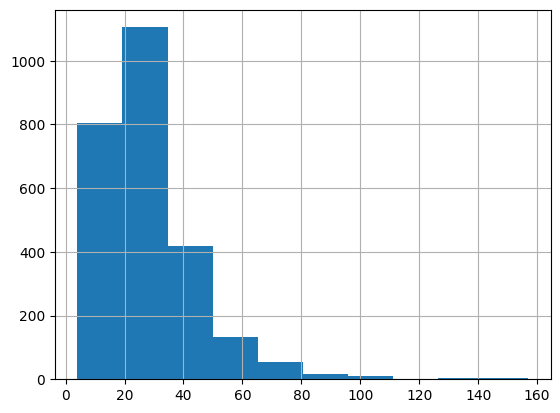

In [117]:
train_text['name'].apply(lambda x: len(tokenizer.encode(x))).hist()

In [118]:
train_text = train_text.astype(str)
val_text = val_text.astype(str)
test_text = test_text.astype(str)

Токенизируем текста, передадим в тензоры и загрузим в функцию DataLoader, которая будет по частям подавать наши данные для обучения и валидации в модель:

In [119]:
tokens_train = tokenizer.batch_encode_plus(
    train_text['name'].values.tolist(),
    max_length = 155,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text['name'].values.tolist(),
    max_length = 155,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text['name'].values.tolist(),
    max_length = 155,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)
batch_size = 8


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

BERT не обучаем. Допишем к его выходу свои слои, которые и будем обучать на классификацию.

In [120]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

Объявим модель, загрузим ее в GPU. Импортируем оптимизатор.

In [121]:
model = BERT_Arch(bert)

model = model.to(device)

optimizer = AdamW(model.parameters(),
               lr= 1e-3)

c:\Users\Mi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Для борьбы с дисбалансом классов используем следующий подход:\
вычисляем взвешенные классы на основе уникальных значений меток  `train_labels` . \
используем кросс-энтропию в качестве функции потерь и устанавливаете количество эпох для обучения.

In [122]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
print(class_weights)
weights = torch.tensor(class_weights, dtype=torch.float)
weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss()
epochs = 20

[0.5405348  6.66753927]


Функция для обучения модели:

In [123]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

Функция валидации:

In [124]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss

Обучаем. Для лучшей метрики на валидации сохраняем веса:

In [ ]:
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    train_loss, _ = train()
    valid_loss = evaluate()
    if valid_loss is not None:  # Проверка на None
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'saved_weights.pt')
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'\nTraining loss: {train_loss:.3f}')
        print(f'Validation loss: {valid_loss:.3f}')
    else:
        print("Evaluation did not return a valid loss value.")


 Epoch1 / 20


100%|██████████| 16/16 [00:01<00:00, 11.10it/s]



Training loss: 0.205
Validation loss: 0.212

 Epoch2 / 20


100%|██████████| 16/16 [00:01<00:00, 10.80it/s]



Training loss: 0.186
Validation loss: 0.217

 Epoch3 / 20


100%|██████████| 16/16 [00:01<00:00, 11.12it/s]



Training loss: 0.181
Validation loss: 0.233

 Epoch4 / 20


100%|██████████| 16/16 [00:01<00:00, 11.03it/s]



Training loss: 0.175
Validation loss: 0.186

 Epoch5 / 20


100%|██████████| 16/16 [00:01<00:00, 11.01it/s]



Training loss: 0.171
Validation loss: 0.191

 Epoch6 / 20


100%|██████████| 16/16 [00:01<00:00, 10.73it/s]



Training loss: 0.170
Validation loss: 0.243

 Epoch7 / 20


100%|██████████| 16/16 [00:01<00:00, 10.79it/s]



Training loss: 0.159
Validation loss: 0.205

 Epoch8 / 20


100%|██████████| 16/16 [00:01<00:00, 10.64it/s]



Training loss: 0.169
Validation loss: 0.180

 Epoch9 / 20


100%|██████████| 16/16 [00:01<00:00, 10.70it/s]



Training loss: 0.164
Validation loss: 0.184

 Epoch10 / 20


100%|██████████| 16/16 [00:01<00:00, 10.12it/s]



Training loss: 0.164
Validation loss: 0.197

 Epoch11 / 20


100%|██████████| 16/16 [00:01<00:00, 11.01it/s]



Training loss: 0.164
Validation loss: 0.170

 Epoch12 / 20


100%|██████████| 16/16 [00:01<00:00, 10.11it/s]



Training loss: 0.161
Validation loss: 0.165

 Epoch13 / 20


100%|██████████| 16/16 [00:01<00:00, 10.22it/s]



Training loss: 0.152
Validation loss: 0.166

 Epoch14 / 20


100%|██████████| 16/16 [00:01<00:00, 10.18it/s]



Training loss: 0.154
Validation loss: 0.176

 Epoch15 / 20


100%|██████████| 16/16 [00:01<00:00, 11.09it/s]



Training loss: 0.140
Validation loss: 0.197

 Epoch16 / 20


100%|██████████| 16/16 [00:01<00:00, 10.97it/s]



Training loss: 0.148
Validation loss: 0.179

 Epoch17 / 20


100%|██████████| 16/16 [00:01<00:00, 10.99it/s]



Training loss: 0.147
Validation loss: 0.164

 Epoch18 / 20


100%|██████████| 16/16 [00:01<00:00, 10.03it/s]



Training loss: 0.144
Validation loss: 0.184

 Epoch19 / 20


100%|██████████| 16/16 [00:01<00:00, 10.47it/s]



Training loss: 0.147
Validation loss: 0.180

 Epoch20 / 20


100%|██████████| 16/16 [00:01<00:00, 10.92it/s]



Training loss: 0.143
Validation loss: 0.156


---------------------------------------
обучили модель и сохранили ее результат.\
проверим на тестовой выборке и использование на боевых данных.

# Загрузим лучшие веса для модели:

In [ ]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

Видеопамяти не хватает для хранения всего что в нее передано, поэтому используем костыль.\
Разобиваю тестовые данные на части и буду отправлять на предсказание по частям

In [ ]:
list_seq = np.array_split(test_seq, 50)
list_mask = np.array_split(test_mask, 50)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())

Преобразую полученные предсказания в один список, нормализую данные и запишу в новый столбик датафрейма.

In [134]:
flat_preds = [item[1] for sublist in predictions for item in sublist]
flat_preds = (flat_preds - min(flat_preds)) / (max(flat_preds) - min(flat_preds))
test_df['confidence'] = flat_preds

На выходе получили значение с плавающей точкой от 0 до 1.\
 Теперь меняя порог, сможем предсказать финальный класс:

In [154]:
threshold = 0.85

test_df['pred'] = test_df['confidence'].apply(lambda x: 1 if x > threshold else 0)

print(classification_report(test_df['label'], test_df['pred']))

roc_auc = roc_auc_score(test_df['label'], test_df['confidence'])
print(f"ROC-AUC: {roc_auc}")

conf_matrix = confusion_matrix(test_df['label'], test_df['pred'])
print("Confusion Matrix:")
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.98      0.87      0.93       471
           1       0.34      0.82      0.48        38

    accuracy                           0.87       509
   macro avg       0.66      0.85      0.71       509
weighted avg       0.94      0.87      0.89       509

ROC-AUC: 0.9149066934853057
Confusion Matrix:
[[412  59]
 [  7  31]]


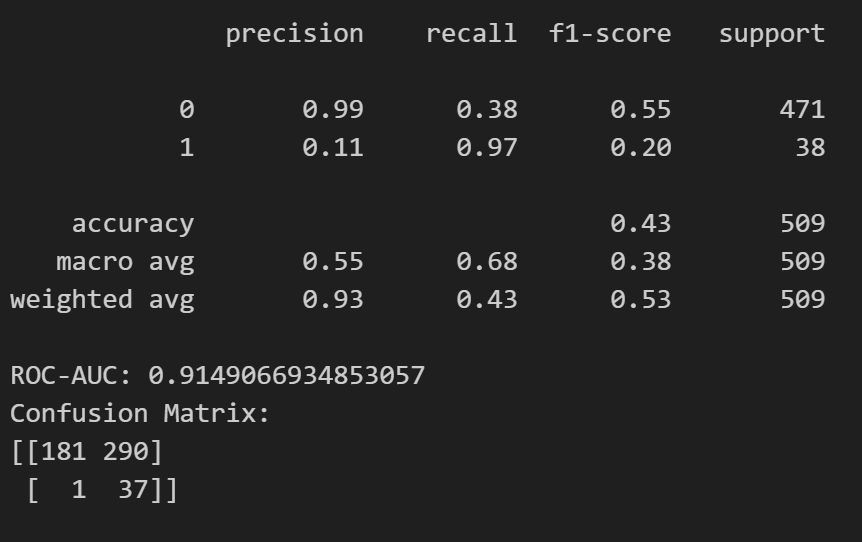